# NISQ Experiment

In [2]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from quantum_tools import *
from quantum_gates import *

#np.set_printoptions(threshold=sys.maxsize)

import numpy as np
import tensorflow as tf
from copy import copy, deepcopy
from scipy.linalg import expm
from utils import *

np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


def swap_unitary(n, q1, q2):
    zero_zero = tf.convert_to_tensor([[1, 0], [0, 0]], dtype=tf.complex128)
    zero_one = tf.convert_to_tensor([[0, 1], [0, 0]], dtype=tf.complex128)
    one_zero = tf.convert_to_tensor([[0, 0], [1, 0]], dtype=tf.complex128)
    one_one = tf.convert_to_tensor([[0, 0], [0, 1]], dtype=tf.complex128)

    d1 = 2**q1
    d2 = 2 ** (q2 - q1 - 1)
    d3 = 2 ** (n - q2 - 1)

    I_d1 = tf.eye(d1, dtype=tf.complex128)
    I_d2 = tf.eye(d2, dtype=tf.complex128)
    I_d3 = tf.eye(d3, dtype=tf.complex128)

    zero_zero_full = kron(I_d1, zero_zero, I_d2, zero_zero, I_d3)
    zero_one_full = kron(I_d1, zero_one, I_d2, one_zero, I_d3)
    one_zero_full = kron(I_d1, one_zero, I_d2, zero_one, I_d3)
    one_one_full = kron(I_d1, one_one, I_d2, one_one, I_d3)

    U = zero_zero_full + zero_one_full + one_zero_full + one_one_full

    return U


def pad_unitary(U, n, target_qubits):
    if not isinstance(target_qubits, list):
        target_qubits = [target_qubits]
    d = U.shape[1]
    num_qubits = int(np.log2(d))

    if num_qubits != len(target_qubits):
        raise ValueError("Gate and target qubits are incompatible")

    q1 = target_qubits[0]
    d1 = 2**q1
    d2 = 2 ** (n - q1 - len(target_qubits))

    U = kron(tf.eye(d1), U)
    U = kron(U, tf.eye(d2))

    if num_qubits > 1:
        q2 = target_qubits[1]
        if q2 != q1 + 1:
            U_swap = swap_unitary(n, q1 + 1, q2)
            U = U_swap @ U @ U_swap

    return U


class Gate:
    def get_unitary(self, n):
        raise NotImplementedError

    def __call__(self, state):
        U = self.get_unitary()
        return tf.linalg.matvec(U, state)


class CNOT(Gate):
    def __init__(self, n, target_qubits):
        self.n = n
        self.target_qubits = target_qubits

    def get_unitary(self):
        U = tf.convert_to_tensor(
            [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]],
            dtype=tf.complex128,
        )
        U = pad_unitary(U, self.n, self.target_qubits)
        return U

    def __call__(self, state):
        U = np.array(
            [[1, 0, 0, 0], 
             [0, 1, 0, 0], 
             [0, 0, 0, 1], 
             [0, 0, 1, 0]],
        )

        U = U.reshape(2,2,2,2)
        U = tf.convert_to_tensor(U, dtype=tf.complex128)
        q1, q2 = self.target_qubits
        state = tf.tensordot(state, U, axes=[[q1+1,q2+1], [1, 2]])
        perm = list(range(self.n+1))
        perm[1], perm[q1+1] = perm[q1+1], perm[1]
        perm[2], perm[q2+1] = perm[q2+1], perm[2]
        #state = tf.transpose(state, perm=perm)

        return state


class Ry(Gate):
    def __init__(self, theta, n, target_qubits):
        self.theta = theta
        self.n = n
        self.target_qubits = target_qubits

        if not isinstance(self.target_qubits, list):
            self.target_qubits = [self.target_qubits]

        self.I = tf.convert_to_tensor(np.array([[[1, 0], [0, 1]]], dtype=np.complex128))
        self.Y = tf.convert_to_tensor(np.array([[[0, -1j], [1j, 0]]], dtype=np.complex128))

    def get_unitary(self):
        U = tf.cos(self.theta / 2) * self.I + 1j * tf.sin(self.theta / 2) * self.Y
        U = pad_unitary(U, self.n, self.target_qubits)
        return U


class Rx(Gate):
    def __init__(self, theta, n, target_qubits):
        self.theta = theta
        self.n = n
        if not isinstance(target_qubits, list):
            target_qubits = [target_qubits]
        self.target_qubits = target_qubits

        self.I = tf.convert_to_tensor(np.array([[[1, 0], [0, 1]]], dtype=np.complex128))
        self.X = tf.convert_to_tensor(np.array([[[0, 1], [1, 0]]], dtype=np.complex128))

    def get_unitary(self):
        U = tf.cos(self.theta / 2) * self.I + 1j * tf.sin(self.theta / 2) * self.X
        U = pad_unitary(U, self.n, self.target_qubits)
        return U


class LadderCNOT(Gate):
    def __init__(self, n):
        self.n = n
        self.gate_list = []
        for i in range(self.n - 1):
            cnot = CNOT(self.n, [i, i + 1])
            self.gate_list.append(cnot)

    def __call__(self, state):
        for gate in self.gate_list:
            state = gate(state)

        return state


class LadderRy(Gate):
    def __init__(self, theta_list, n):
        self.theta_list = theta_list
        self.n = n
        self.gate_list = []
        num_features = self.theta_list.shape[1]

        for i in range(self.n):
            i_ = i%num_features
            theta = tf.cast(self.theta_list[:,i_], tf.complex128)
            ry = Ry(theta, self.n, i)
            self.gate_list.append(ry)
    
    def __call__(self, state):
        for gate in self.gate_list:
            state = gate(state)
            
        return state


class LadderRx(Gate):
    def __init__(self, theta_list, n):
        self.theta_list = theta_list
        self.n = n
        self.gate_list = []

        for i in range(self.n):
            theta = tf.cast(self.theta_list[i], tf.complex128)
            rx = Rx(theta, self.n, i)
            self.gate_list.append(rx)

    def __call__(self, state):
        for gate in self.gate_list:
            state = gate(state)

        return state


class QNN:
    def __init__(self, n, num_layers):
        self.n = n
        self.num_layers = num_layers

        self.d = 2**n

        self.params = []
        for i in range(num_layers):
            theta_list = tf.Variable(tf.random.uniform([n, 1, 1], -np.pi, np.pi, dtype=tf.float64), trainable=True)
            self.params.append(theta_list)
        
        #weights = tf.Variable(tf.random.normal([n, 2], dtype=tf.float64), trainable=True)
        #self.params.append(weights)

    def __call__(self, inputs):
        batch_dim = inputs.shape[0]
        state = np.zeros((1, self.d))
        state[0, 0] = 1
        state = tf.convert_to_tensor(state, dtype=tf.complex128)
        state = tf.repeat(state, batch_dim, axis=0)

        inputs = inputs.reshape(*(inputs.shape), 1, 1)
        inputs = tf.cast(inputs, tf.complex128)

        cnotLadder = LadderCNOT(self.n)
        for i in range(self.num_layers):
   
            ry = LadderRy(inputs, self.n)
            rx = LadderRx(self.params[i], self.n)
            state = ry(state)
            state = rx(state)
            if i != self.num_layers - 1:
                state = cnotLadder(state)

        prob = tf.abs(state) ** 2
        prob = prob.reshape(batch_dim, *self.n*[2])
        prob_list = []
        for i in range(self.n):
            prob_list.append(tf.math.reduce_sum(prob, axis=[j for j in range(1, self.n+1) if j != (i+1)]))
        prob_list = tf.stack(prob_list, axis=1)[:, :, 0]
        return prob_list
    

class DNN:
    def __init__(self, num_layers):
        self.num_layers = num_layers
        self.params = []
        for i in range(num_layers):
            theta_list = tf.Variable(tf.random.uniform([1, 1], -np.pi, np.pi, dtype=tf.float64), trainable=True)
            self.params.append(theta_list)


def trajectory_length(outputs):
    dist = tf.norm(outputs[1:] - outputs[:-1])
    return dist
    



In [3]:
class QNN:
    def __init__(self, n, num_layers):
        self.n = n
        self.num_layers = num_layers

        self.d = 2**n

        self.params = []
        for i in range(num_layers):
            theta_list = tf.Variable(tf.random.uniform([n, 1, 1], -np.pi, np.pi, dtype=tf.float64), trainable=True)
            self.params.append(theta_list)
        
        #weights = tf.Variable(tf.random.normal([n, 2], dtype=tf.float64), trainable=True)
        #self.params.append(weights)

    def __call__(self, inputs):
        batch_dim = inputs.shape[0]
        state = np.zeros((1, self.d))
        state[0, 0] = 1
        state = state.reshape(1, *(self.n*[2]))
        state = tf.convert_to_tensor(state, dtype=tf.complex128)
        state = tf.repeat(state, batch_dim, axis=0)

        inputs = inputs.reshape(*(inputs.shape), 1, 1)
        inputs = tf.cast(inputs, tf.complex128)

        cnotLadder = LadderCNOT(self.n)
        for i in range(self.num_layers):
   
            ry = LadderRy(inputs, self.n)
            rx = LadderRx(self.params[i], self.n)
            state = ry(state)
            state = rx(state)
            if i != self.num_layers - 1:
                state = cnotLadder(state)

        prob = tf.abs(state) ** 2
        prob = prob.reshape(batch_dim, *self.n*[2])
        prob_list = []
        for i in range(self.n):
            prob_list.append(tf.math.reduce_sum(prob, axis=[j for j in range(1, self.n+1) if j != (i+1)]))
        prob_list = tf.stack(prob_list, axis=1)[:, :, 0]
        #weights = self.params[-1]
        #weights = tf.math.sigmoid(weights)
        #prob_list = prob_list@weights
        return prob_list



class CNOT(Gate):
    def __init__(self, n, target_qubits):
        self.n = n
        self.target_qubits = target_qubits

    def get_unitary(self):
        U = tf.convert_to_tensor(
            [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]],
            dtype=tf.complex128,
        )
        U = pad_unitary(U, self.n, self.target_qubits)
        return U

    def __call__(self, state):
        U = np.array(
            [[1, 0, 0, 0], 
             [0, 1, 0, 0], 
             [0, 0, 0, 1], 
             [0, 0, 1, 0]],
        )

        U = U.reshape(2,2,2,2)
        U = tf.convert_to_tensor(U, dtype=tf.complex128)
        q1, q2 = self.target_qubits
        #print(state.shape)
        #state = tf.tensordot(U, state, axes=[[2, 3], [q1+1,q2+1]])
        string = "efghijklmnopqrstuvwxy"
        string = string[:self.n]
        string = string[:q1] + "c" + string[q1+1:q2] + "d"  + string[q2+1:]
        string_new = string[:q1]  + string[q1+1:q2] + string[q2+1:]

        state = tf.einsum("abcd,z" + string + "->zab" + string_new, U, state)
        state = tf.experimental.numpy.moveaxis(state, (1, 2), (q1+1, q2+1))

        return state
    

class Ry(Gate):
    def __init__(self, theta, n, target_qubits):
        self.theta = theta
        self.n = n
        self.target_qubits = target_qubits

        if not isinstance(self.target_qubits, list):
            self.target_qubits = [self.target_qubits]

        self.I = tf.convert_to_tensor(np.array([[[1, 0], [0, 1]]], dtype=np.complex128))
        self.Y = tf.convert_to_tensor(np.array([[[0, -1j], [1j, 0]]], dtype=np.complex128))

    def get_unitary(self):
        U = tf.cos(self.theta / 2) * self.I + 1j * tf.sin(self.theta / 2) * self.Y
        U = pad_unitary(U, self.n, self.target_qubits)
        return U
    
    def __call__(self, state):
        batch = state.shape[0]
        U = tf.cos(self.theta / 2) * self.I + 1j * tf.sin(self.theta / 2) * self.Y
        U = U.reshape(batch, 2, 2)

        q1 = self.target_qubits[0]
        string = "cdefghijklmnopqrstuvwxy"
        string = string[:self.n]
        string = string[:q1] + "b" + string[q1+1:]
        string_new = string[:q1] + string[q1+1:]

        #state = tf.tensordot(U, state, axes=[1, q1+1])
        #print(U.shape, state.shape)
        state = tf.einsum("zab,z" + string + "->za" + string_new, U, state)
        state = tf.experimental.numpy.moveaxis(state, 1, q1+1)

        return state
    

class Rx(Gate):
    def __init__(self, theta, n, target_qubits):
        self.theta = theta
        self.n = n
        self.target_qubits = target_qubits

        if not isinstance(self.target_qubits, list):
            self.target_qubits = [self.target_qubits]

        self.I = tf.convert_to_tensor(np.array([[[1, 0], [0, 1]]], dtype=np.complex128))
        self.X = tf.convert_to_tensor(np.array([[[0, 1], [1, 0]]], dtype=np.complex128))

    def get_unitary(self):
        U = tf.cos(self.theta / 2) * self.I + 1j * tf.sin(self.theta / 2) * self.X
        U = pad_unitary(U, self.n, self.target_qubits)
        return U

    def __call__(self, state):
        U = tf.cos(self.theta / 2) * self.I + 1j * tf.sin(self.theta / 2) * self.X
        U = U.reshape(2, 2)

        q1 = self.target_qubits[0]
        string = "cdefghijklmnopqrstuvwxy"
        string = string[:self.n]
        string = string[:q1] + "b" + string[q1+1:]
        string_new = string[:q1] + string[q1+1:]

        #state = tf.tensordot(U, state, axes=[1, q1+1])
        state = tf.einsum("ab,z" + string + "->za" + string_new, U, state)
        state = tf.experimental.numpy.moveaxis(state, 1, q1+1)

        return state
        

In [184]:
n = 10
d = 2**n
N=100


tf.random.set_seed(42)
state = np.random.normal(0,1,(N, d))
state[:, 0] = 1
state = state.reshape(N, *(n*[2]))
state = tf.convert_to_tensor(state, dtype=tf.complex128)

cnot = CNOT(n, [2, 4])

state_new = cnot(state)
state_old = tf.linalg.matvec(cnot.get_unitary(), (state.reshape(N, d))).reshape(N, *(n*[2]))

print(tf.norm(state_new - state_old))

print(state_new.shape)

(100, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
tf.Tensor(0j, shape=(), dtype=complex128)
(100, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)


In [199]:
tf.random.set_seed(42)
n = 8
N = 1000
qnn = QNN(n, n)
t = np.linspace(0, 2*np.pi, N)
inputs = np.pi/2*np.array([np.sin(t), np.cos(t)]).T
inputs = inputs
state = qnn(inputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [200]:
for i in tqdm(range(1000)):
    with tf.GradientTape() as tape:
        state = qnn(inputs)
        dist = tf.math.sqrt((state[1:,0] - state[:-1,0])**2 + (state[1:,1] - state[:-1,1])**2)
        loss = -tf.reduce_sum(dist)
    grads = tape.gradient(loss, qnn.params)
    optimizer.apply_gradients(zip(grads, qnn.params))
    if i%10 == 0:
        print(loss.numpy())
    

  0%|          | 0/1000 [00:00<?, ?it/s]

-2.0070698180644007


KeyboardInterrupt: 

## Multidim Trajectory Length

In [13]:
n = 8
d = 2**n

N = 1000
t = np.linspace(0, 2*np.pi, N)
inputs = np.pi/2*np.array([np.sin(t), np.cos(t)]).T
inputs = tf.cast(inputs, tf.complex128)

tf.random.set_seed(42)

qnn = QNN(n, 2*n)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
outputs1 = qnn(inputs)

In [18]:
for i in tqdm(range(100)):
    with tf.GradientTape() as tape:
        outputs = qnn(inputs)
        loss = -trajectory_length(outputs)
    
    grads = tape.gradient(loss, qnn.params)   
    optimizer.apply_gradients(zip(grads, qnn.params))

    if i%10 == 0:
        print(loss.numpy())

outputs2 = qnn(inputs)


  0%|          | 0/100 [00:00<?, ?it/s]

-0.2901103175891377
-0.2901957498135162
-0.29020529897100805
-0.29020929417469005
-0.29021286320903666
-0.2902132559054995
-0.29021351304113713
-0.29021361983466504
-0.2902136283412977
-0.2902136462628394


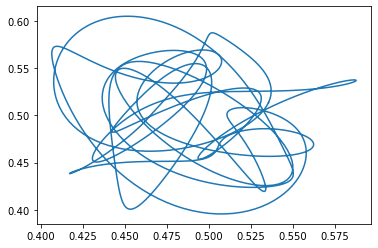

In [17]:
plt.plot(outputs2[:,0], outputs2[:,1])
#plt.plot(outputs2[:,0], outputs2[:,1])


In [85]:
tf.random.set_seed(42)

#targets = qnn(inputs)

dnn = tf.keras.Sequential()
dnn.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(2,)))
dnn.add(tf.keras.layers.Dense(32, activation='relu'))
dnn.add(tf.keras.layers.Dense(n, activation='sigmoid'))

optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.01, decay=0.05)
targets = qnn(inputs)

In [86]:
for i in tqdm(range(10000)):
    with tf.GradientTape() as tape:
        outputs = dnn(inputs)
        loss = tf.math.reduce_mean((outputs - targets)**2)
    
    grads = tape.gradient(loss, dnn.trainable_variables)   
    optimizer2.apply_gradients(zip(grads, dnn.trainable_variables))

    if i%10 == 0:
        print(loss.numpy())

  0%|          | 0/10000 [00:00<?, ?it/s]

0.008581430184950004
0.005077254740600878
0.00471741177324908
0.004507614687297152
0.004322345943357288
0.004149523768742972
0.003984985864904298
0.003828307125730302
0.0036791305053131104
0.0035381914142858344
0.0034057344003073464
0.003282061536621316
0.003168620492618673
0.003063183965357252
0.0029643985781795446
0.0028717643425832154
0.0027844682058381504
0.002696305541821353
0.002616487905402573
0.00254388263905528
0.0024767653382038097
0.0024144364843805633
0.002356139497195582
0.0023016439294437393
0.002250548460726174
0.0022025032459500596
0.0021572635401496294
0.0021145590045636483
0.00207414455906673
0.002035792735789578
0.001999193559044661
0.0019641346802238284
0.0019304890577582544
0.0018983973301055512
0.0018679465408855576
0.0018390254418159412
0.001810504533579499
0.0017834642457197805
0.0017576752715324697
0.0017329847470878938
0.0017096283198697359
0.0016872370420062505
0.0016657111347086766
0.001644974864707684
0.0016250114820677028
0.0016057229987978675
0.0015870680

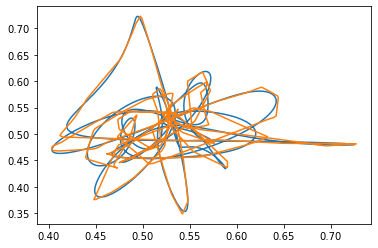

In [84]:
plt.plot(targets[:,2], targets[:,3])
plt.plot(outputs[:,2], outputs[:,3])